In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
from sympy import (
    Derivative, 
    S, 
    Symbol, 
    series, 
    sqrt, 
    symbols, 
    oo, 
    limit, 
    Rational, 
    cos, 
    sin, 
    cosh, 
    sinh, 
    Matrix, 
    simplify, 
    latex, 
    lambdify,
    Function,
    collect,
    lambdify,
    solve,
    Eq,
    Poly,
    diff,
    nsolve,
    O,
    I,
    sqrt,
    pi,
    Add,
    latex,
    transpose
)
from sympy.core.numbers import NegativeOne, One, Zero
import numpy as np
import pandas as pd
from sympy import init_printing
init_printing() 

from sympy.printing.latex import print_latex
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook
#from pymad_hzb.PlotTools import new_plot_elems_madx
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

from tqdm import tqdm

In [3]:
from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbFODO, 
    RsymbDrift6D, 
    RsymbQuad6D, 
    RsymbQuad6DChroma, 
    RsymbQuad6DThin
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpFODO, 
    RnpDrift6D, 
    RnpQuad6D, 
    RnpQuad6DChroma, 
    RnpQuad6DThin
)
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
    HamSQuad6D,
    HamSext6D
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket

from acchamiltoniansandmatrices.Utils.JupyterHelpFunctions import hide_toggle
from acchamiltoniansandmatrices.Utils.SymbolicFunctions import SymbolTrick, fixedpoints2D
from acchamiltoniansandmatrices.Utils.Plotting import multi_countour_plot

from acchamiltoniansandmatrices.Factorization.Factorization import truncate, taylorize
from acchamiltoniansandmatrices.Tracking.LieMapTracking import AssignHam, RingHam
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList
from acchamiltoniansandmatrices.Utils.Polynomials import getpoly, RotationMatrix2D, explicitCheck, geteigenvects

In [4]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

# standardized substitutions that are useful - ORDER IN LISTS COUNTS !!!!
betagamma_rep = list(zip([beta0*gamma0,beta0],[oo,1]))
series_rep = list(zip([px,py,delta],[eps*px,eps*py,eps*delta]))
coord_rep = list(zip([x,y],[eps*x,eps*y]))
thin_rep = list(zip([px,py,delta],[0,0,0]))
xpx_rep = list(zip([y,py,delta],[0,0,0]))

In [200]:
def AssignHam(element, order=3, length=1, k=1,flag=1):
    '''
    Element:
    1 = drift space
    2 = quadrupole
    25 = skew quadrupole
    3 = sextupole
    35 = skew sextupole - tbp
    '''
    order = order +1
    betagamma_rep = list(
        zip(
            [
                beta0*gamma0,
                beta0
            ],
            [
                oo,
                1
            ]
        )
    )
    series_rep = list(
        zip(
            [
                px,
                py,
                delta
            ],
            [
                eps*px,
                eps*py,
                eps*delta
            ]
        )
    )
    coord_rep = list(zip([x,y],[eps*x,eps*y]))

    thin_rep = list(zip([px,py,delta],[0,0,0]))
    if element == 1:
        # drift hamiltonian
        H = NegativeOne() * HamDrift6D(beta0, gamma0, length,x,px,y,py,delta)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
#         H = drift(order, length)
        
    elif element == 2:
        # quadrupole - thin is set by flag
        H = NegativeOne() * Rational(1,2) * HamQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
#         
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
        
#         H = quad(order, length, strength, flag)
    elif element == 25:
        H = NegativeOne() * Rational(1,2) * HamSQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
#         H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
#         H = skew_quad(order, length, strength, flag)
        
    elif element == 3:
        H = NegativeOne() * Rational(1,2) * HamSext6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
#         H = sext(order, length, strength, flag)
#     elif H == 35:
#         H = skew_sext(order, length, strength)
    else:
        raise ValueError(element, ' no such reference in library.')      
    
    return H


def truncate(LieHam,degree): #cutoff Hamiltonian at specified degree
    degree = degree+1
    _epstemp = symbols('e')
    fct = LieHam.ham
    
    for i in LieHam.indep_coords:
        fct = fct.subs(i,i*_epstemp)
        
    for i in LieHam.indep_mom:
        fct = fct.subs(i,i*_epstemp)
    
    fct = fct.expand()
    fct = fct + O(_epstemp**degree)
    fct = fct.removeO().subs(_epstemp,1)
    
    return fct


def RingHam(beamline,BCH_order,poly_cutoff, doit=False): #combine beamline with BCH into one map
    poly_cutoff = poly_cutoff + 1
    for i,element in enumerate(beamline):
        if i == 0:
            H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
            H_int = LieOperator(H0,[x,y,z],[px,py,delta])
        else:
            H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
            H0 = LieOperator(H0,[x,y,z],[px,py,delta])
            
            H_int = H_int.BCH(H0,BCH_order)
            
        
            H_int = H_int.doit()
    
    temp_H = truncate(H_int,poly_cutoff) #cutoff Hamiltonian at speciefied polynomial degree
    
    H = LieOperator(temp_H,[x,y,z],[px,py,delta])
    
    
    return H

def codict(expr, *x):
    collected = Poly(expr, *x).as_expr()
    return dict(i.as_independent(*x)[::-1] for i in Add.make_args(collected))

In [187]:
# redefine for use in ringham - otherwise assumption errors
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")
dld   = symbols('\delta{L_D}') # delta length drift

In [188]:
thin = 1
bchorder = 4
torder = 4

eldict = {
    'drift' : 1,
    'quad'  : 2,
    'squad' : 25,
    'sext'  : 3
}

beamline = [
    [eldict['quad'] , 4, LQF, KQF, 0],
    [eldict['drift'], 6, LD , Zero(), 0   ],
#     [eldict['quad'] , 2, Rational(1,2) * LQD, KQD, thin],
    [eldict['quad'] , 4, LQD, KQD, 0],
    [eldict['drift'], 6, LD + dld,   Zero(), 0   ],
    [eldict['quad'] , 4, LQF, KQF, 0],
]

In [206]:
rep = list(zip(
    [
        LD,
        LD2,
        LQF,
        LQD,
        KQF,
        KQD,
        delta,
        dld
    ],
    [
        2.55,
        2.55,
        0.3,
        0.804,
        0.7,#7,
        -0.35,
        0,
        -.2,#-.2
    ]
)
          )

In [214]:
rep = list(zip(
    [
        LD,
        LD2,
        LQF,
        LQD,
        KQF,
        KQD,
        delta,
        dld
    ],
    [
        3.5805,
        3.5805,
        0.342,
        0.668,
        0.49,
        -0.4999,
        1.5e-3,
        0
    ]
)
          )


# Left to right BCH order 2

In [216]:
element = beamline[0]
HQF = AssignHam(element[0],4,element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
tqf = taylorize(LieOperator(HQF,[x],[px]),4)
tqfx = lambdify((x,px), tqf[0])
tqfpx = lambdify((x,px),tqf[1])

element = beamline[1]
HD1 = AssignHam(element[0],4,element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
td  = taylorize(LieOperator(HD1,[x],[px]),4)
tdx = lambdify((x,px), td[0])
tdpx = lambdify((x,px),td[1])


element = beamline[2]
HQD = AssignHam(element[0],4,element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
tqd = taylorize(LieOperator(HQD,[x],[px]),4)
tqdx = lambdify((x,px), tqd[0])
tqdpx = lambdify((x,px),tqd[1])


In [ ]:
def quadf(r):
    _x = r[:,0]
    _px = r[:,1]
    
    xn = tqfx(_x,_px)
    pxn = tqfpx(-x,_px)
    
    z0 = np.zeros(r[:,0].shape)
    return np.array([xn,pxn,z0,z0,z0,z0]).transpose()
 

In [ ]:
r0 = np.array([
    [10e-7,eps,10e-7,eps,eps,dev],
#                [10e-5,eps,10e-5,eps,eps,dev],
#                [10e-3,eps,10e-3,eps,eps,dev],
#                [10e-1,eps,10e-1,eps,eps,dev],
#                [0.25,eps,0.25,eps,eps,dev],
#                [0.35,eps,0.35,eps,eps,dev],
#                [0.45,eps,0.45,eps,eps,dev],
#                [0.55,eps,0.55,eps,eps,dev],
#                [0.65,eps,0.65,eps,eps,dev],
#                [0.8,eps,0.8,eps,eps,dev],
#                [0.9,eps,0.9,eps,eps,dev],
#                [1,eps,1,eps,eps,dev],
#                [1.1,eps,1.1,eps,eps,dev],
#                [1.2,eps,1.2,eps,eps,dev],
#                [1.3,eps,1.3,eps,eps,dev],
#                [1.4,eps,1.4,eps,eps,dev],
#                [1.5,eps,1.5,eps,eps,dev],
#                [1.6,eps,1.6,eps,eps,dev],
#                [1.7,eps,1.7,eps,eps,dev],
#                [1.8,eps,1.8,eps,eps,dev],
#                [1.9,eps,1.9,eps,eps,dev],
#                [2.0,eps,2.0,eps,eps,dev]
              ]
             )

X_Exact = []
X_Exact = np.array([r0])

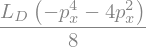

In [201]:
element = beamline[1]
H = AssignHam(element[0],4,element[2],element[3],element[4]).subs(xpx_rep)#.subs(rep)
H

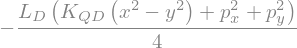

In [162]:
H = NegativeOne() * Rational(1,2) * HamQuad6D(beta0,gamma0,LD,x,px,y,py,delta,KQD)
H = H.subs(betagamma_rep)
#         
H = H.subs(series_rep).series(eps,n=3).removeO()
H = H.subs(coord_rep)

H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
H

In [202]:
tqf = taylorize(LieOperator(H,[x],[px]),4)

In [203]:
tqff = lambdify((x,px),tqf[0].subs(rep))

In [204]:
tqff(0,0.1)

In [452]:
eps = symbols('epsilon')

In [468]:
%%timeit
sales_rep = list(zip([x,y,z,px,py,delta],[x*eps,y*eps,z*eps,px*eps,py*eps,delta*eps]))
pol = S(0)
for a in Add.make_args(H_int.ham):
#     print(a.subs(sales_rep)+O(eps**4))
    test = a.subs(sales_rep)+O(eps**4)
    if(test!=O(eps**4)):
        pol+= test.removeO().subs(eps,1)
        
pol

665 µs ± 9.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [471]:
%%timeit
truncate(H_int,4)

78.1 µs ± 833 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [207]:
element = beamline[0]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H_int = LieOperator(H0,[x],[px]).doit()

element = beamline[1]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int = H_int.BCH(H0,bchorder).doit()
H_int = truncate(H_int,torder)
H_int = LieOperator(H_int,[x],[px]).doit()

element = beamline[2]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int = H_int.BCH(H0,bchorder).doit()
H_int = truncate(H_int,torder)
H_int = LieOperator(H_int,[x],[px]).doit()

# next element
element = beamline[3]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int = H_int.BCH(H0,bchorder).doit()
H_int = truncate(H_int,torder)
H_int = LieOperator(H_int,[x],[px]).doit()

# # next element
element = beamline[4]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int = H_int.BCH(H0,bchorder).doit()
H_int = truncate(H_int,torder)
H_int = LieOperator(H_int,[x],[px]).doit()

codict(H_int.ham.subs(xpx_rep).expand(),x,px)

# Right to left BCH

In [208]:
element = beamline[4]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H_int2 = LieOperator(H0,[x],[px]).doit()

element = beamline[3]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int2 = H_int2.BCH(H0,bchorder).doit()
H_int2 = truncate(H_int2,torder)
H_int2 = LieOperator(H_int2,[x],[px]).doit()

element = beamline[2]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int2 = H_int2.BCH(H0,bchorder).doit()
H_int2 = truncate(H_int2,torder)
H_int2 = LieOperator(H_int2,[x],[px]).doit()

# next element
element = beamline[1]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int2 = H_int2.BCH(H0,bchorder).doit()
H_int2 = truncate(H_int2,torder)
H_int2 = LieOperator(H_int2,[x],[px]).doit()

# next element
element = beamline[0]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int2 = H_int2.BCH(H0,bchorder).doit()
H_int2 = truncate(H_int2,torder)
H_int2 = LieOperator(H_int2,[x],[px]).doit()



# BCH symm middle

In [209]:
eldict = {
    'drift' : 1,
    'quad'  : 2,
    'squad' : 25,
    'sext'  : 3
}

beamlines = [
    [eldict['quad'] , 4, LQF, KQF, 0],
    [eldict['drift'], 6, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQD, KQD, 0],
    [eldict['drift'], 6, LD + dld,   Zero(), 0   ],
    [eldict['quad'] , 4, LQF, KQF, 0],
]

In [210]:
element = beamlines[0]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H_int3l = LieOperator(H0,[x],[px,]).doit()

element = beamlines[1]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int3l = H_int3l.BCH(H0,bchorder).doit()
H_int3l = truncate(H_int3l,torder)
H_int3l = LieOperator(H_int3l,[x],[px]).doit()

# H_int3l.ham.expand()
element = beamlines[2]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H_int3m = LieOperator(H0,[x],[px]).doit()

# element = beamlines[3]
# H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
# H0 = LieOperator(H0,[x],[px])
# H_int3m = H_int3m.BCH(H0,bchorder).doit()

# H_int3m.ham.expand()

element = beamlines[3]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H_int3r = LieOperator(H0,[x],[px]).doit()

element = beamlines[3]
H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
H0 = LieOperator(H0,[x],[px])
H_int3r = H_int3r.BCH(H0,bchorder).doit()
H_int3r = truncate(H_int3r,torder)
H_int3r = LieOperator(H_int3r,[x],[px]).doit()

H_int3 = H_int3l.BCH(H_int3m,bchorder).doit()
H_int3 = truncate(H_int3,torder)
H_int3 = LieOperator(H_int3,[x],[px]).doit()

H_int3 = H_int3.BCH(H_int3r,bchorder).doit()
H_int3 = truncate(H_int3,torder)
H_int3 = LieOperator(H_int3,[x],[px]).doit()

<IPython.core.display.Javascript object>


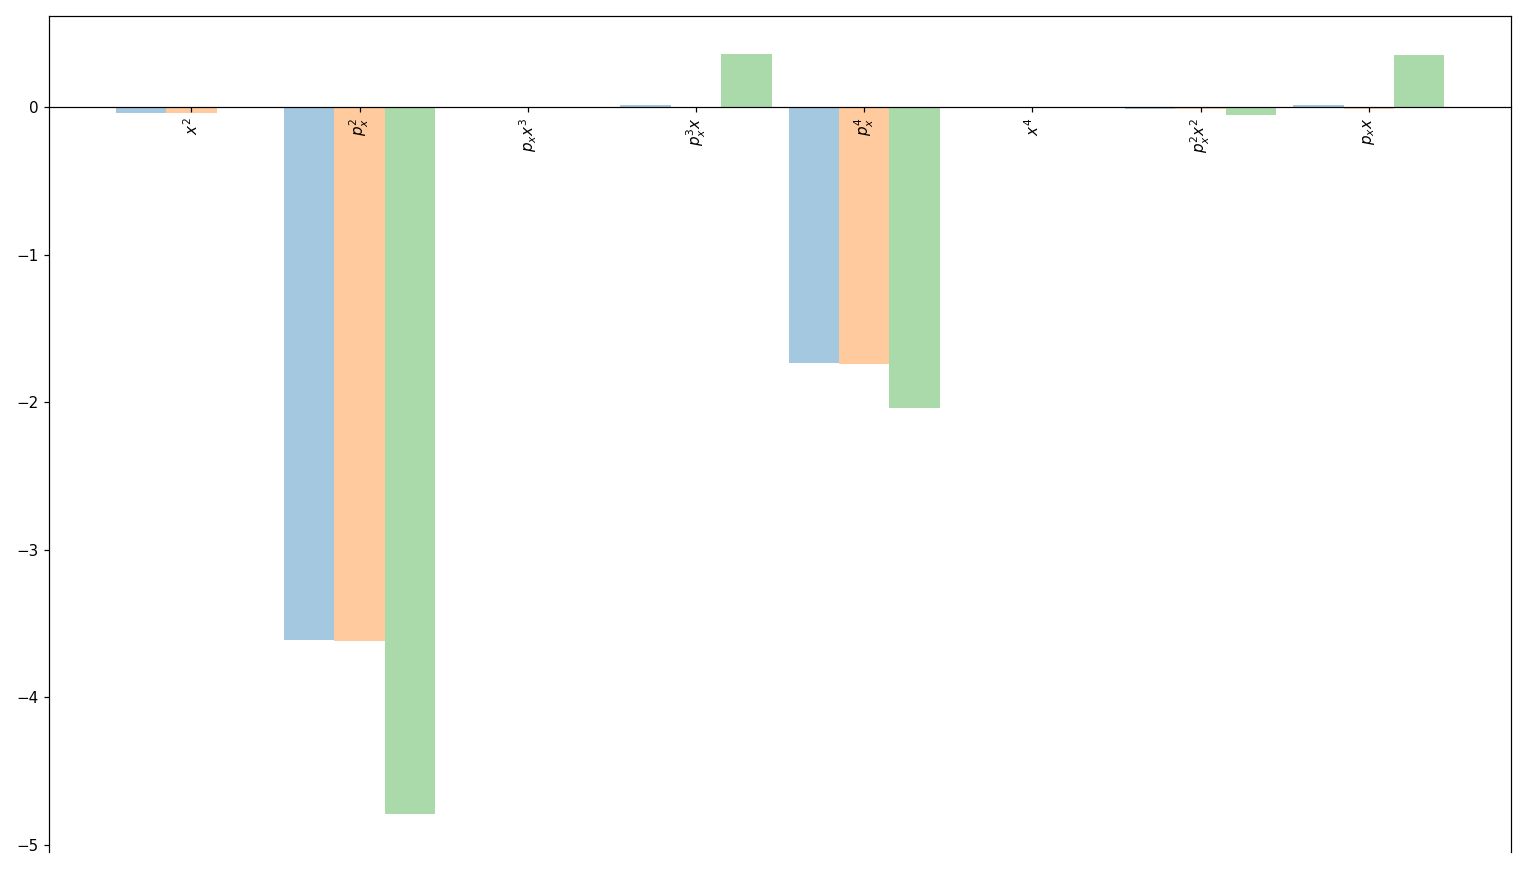

In [211]:
cd  = codict(H_int.ham.subs(xpx_rep).expand(),x,px)
cd2 = codict(H_int2.ham.subs(xpx_rep).expand(),x,px)
cd3 = codict(H_int3.ham.subs(xpx_rep).expand(),x,px)

w = 0.3

_keys = (set(cd.keys()).union(set(cd2.keys()))).union(set(cd3.keys()))

vals1 = [cd.get(k,0.0) for k in _keys]
vals2 = [cd2.get(k,0.0) for k in _keys]
vals3 = [cd3.get(k,0.0) for k in _keys]

fig= plt.figure(figsize=(14,8))
plt.bar(np.arange(len(_keys)) - w, vals1, width=w, align='center', alpha=.4)
plt.bar(np.arange(len(_keys))    , vals2, width=w, align='center', alpha=.4)
plt.bar(np.arange(len(_keys)) + w, vals3, width=w, align='center', alpha=.4)
# plt.bar(range(len(cd3)), list(cd3.values()), align='center', alpha=.4)
ax= plt.gca()
ax.spines['bottom'].set_position('zero')
plt.xticks(range(len(_keys)), list([r"${}$".format(latex(k)) for k in _keys]), rotation=90)
plt.tight_layout()

In [15]:
cd

In [212]:
cd

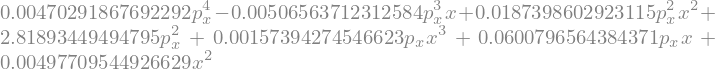

In [16]:
H_int.ham

In [1068]:
cd3

<IPython.core.display.Javascript object>


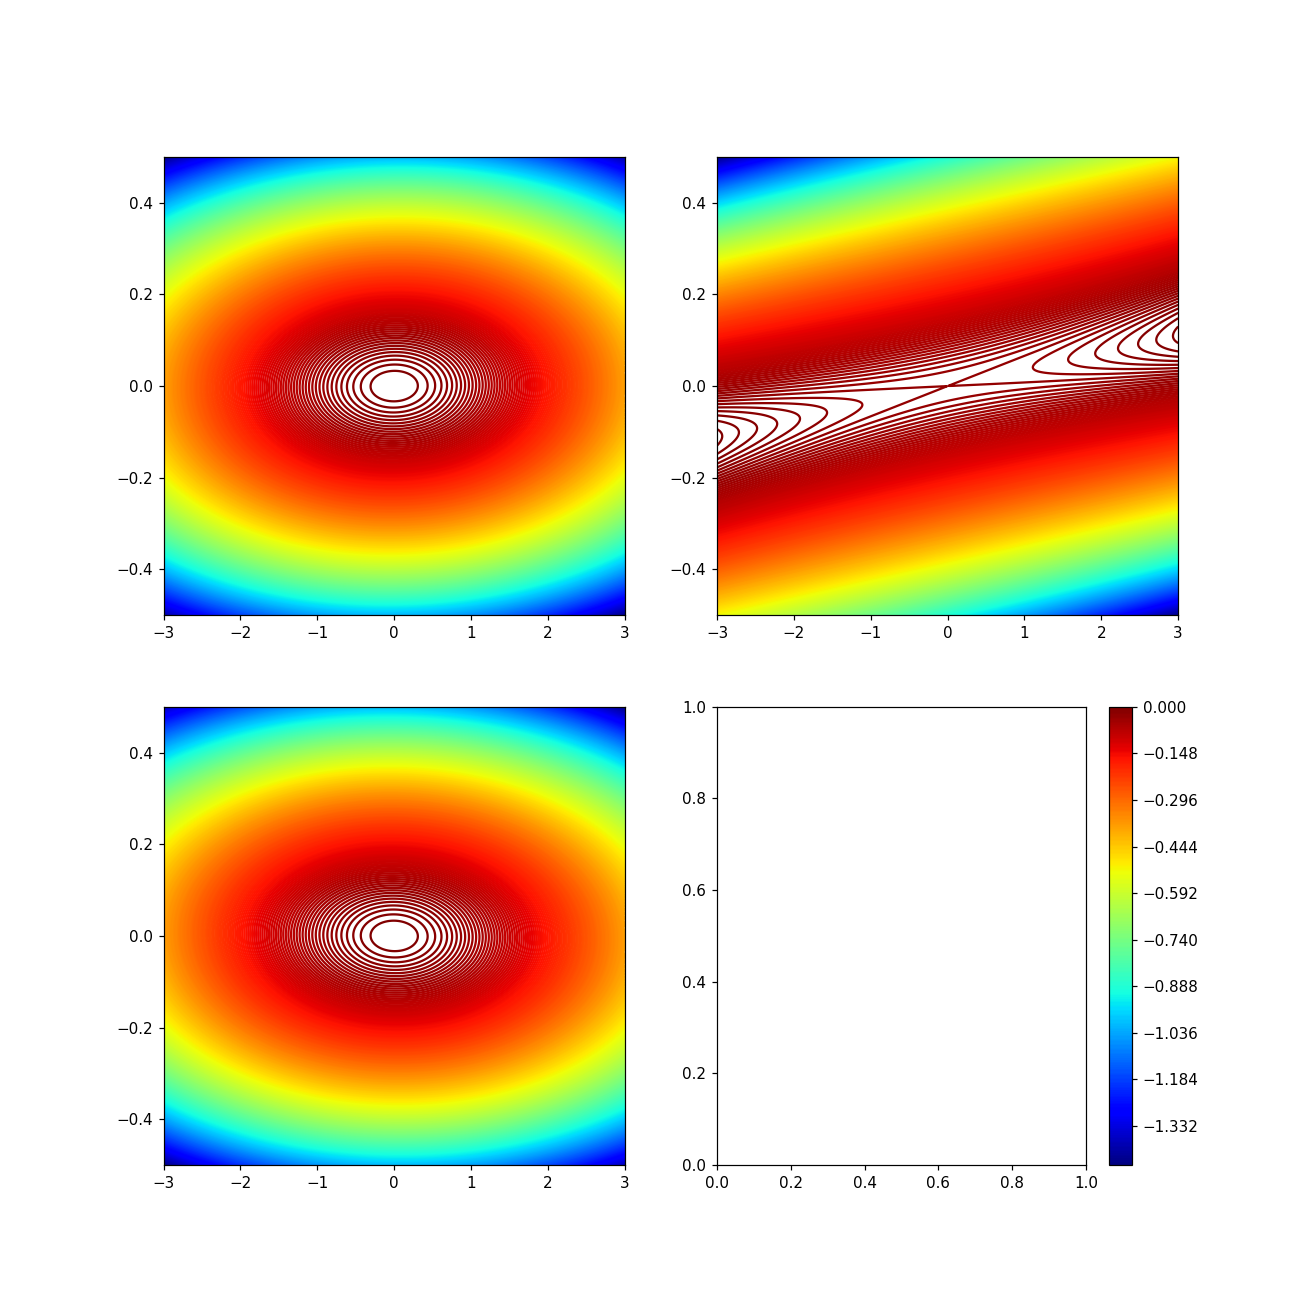

In [213]:
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(2, 2)
axes = [fig.add_subplot(gs[i, j]) for j in range(2) for i in range(2)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 3
prange = .5
npoints= 800
X = np.linspace(-xrange, xrange, npoints)
# X = np.linspace(1, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

func1 = lambdify((x,px), H_int.ham.expand().subs(xpx_rep),'numpy')
# func1 = lambdify((x,px), cd[px**3*x] * px**3*x +  cd.get(x**3*px,0)* x**3*px  + cd[x**2*px**2] * x**2*px**2)
func2 = lambdify((x,px), H_int2.ham.expand().subs(xpx_rep) ,'numpy')
# func2 = lambdify((x,px), + cd3[x**2*px**2] * x**2*px**2  ) #cd3[px**2]*px**2 + cd3[x*px]*x*px + cd3[x**2]*x**2)
func3 = lambdify((x,px), H_int3.ham.expand().subs(xpx_rep) ,'numpy')
# func3 = lambdify((x,px), cd3[px**3*x] * px**3*x +  cd3.get(x**3*px,0)* x**3*px    )

Hlist = [func1(Xg, Pg),func2(Xg,Pg),func3(Xg,Pg)]

axes[0].contour(Xg, Pg, Hlist[0], levels=450,cmap=cm.jet)
cb = axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
axes[2].contour(Xg, Pg, Hlist[2], levels=450,cmap=cm.jet)
plt.colorbar(cb)

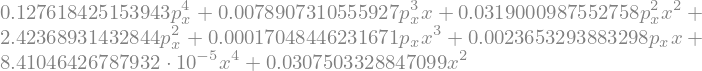

In [82]:
H_int.ham

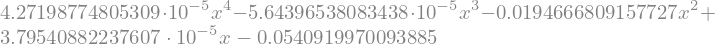

In [115]:
H_int.ham.subs(px,0.1)

In [117]:
H_int.ham.subs(x,0)

In [128]:
diff(H_int.ham.subs(x,0))

In [131]:
solve(diff(H_int.ham.subs(px,0.1),x),x)

In [127]:
solve(diff(H_int.ham.subs(px,0.0),x),x)

In [129]:
solve(diff(H_int.ham.subs(x,0),px),px)

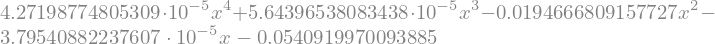

In [121]:
H_int.ham.subs(px,-0.1)

<IPython.core.display.Javascript object>


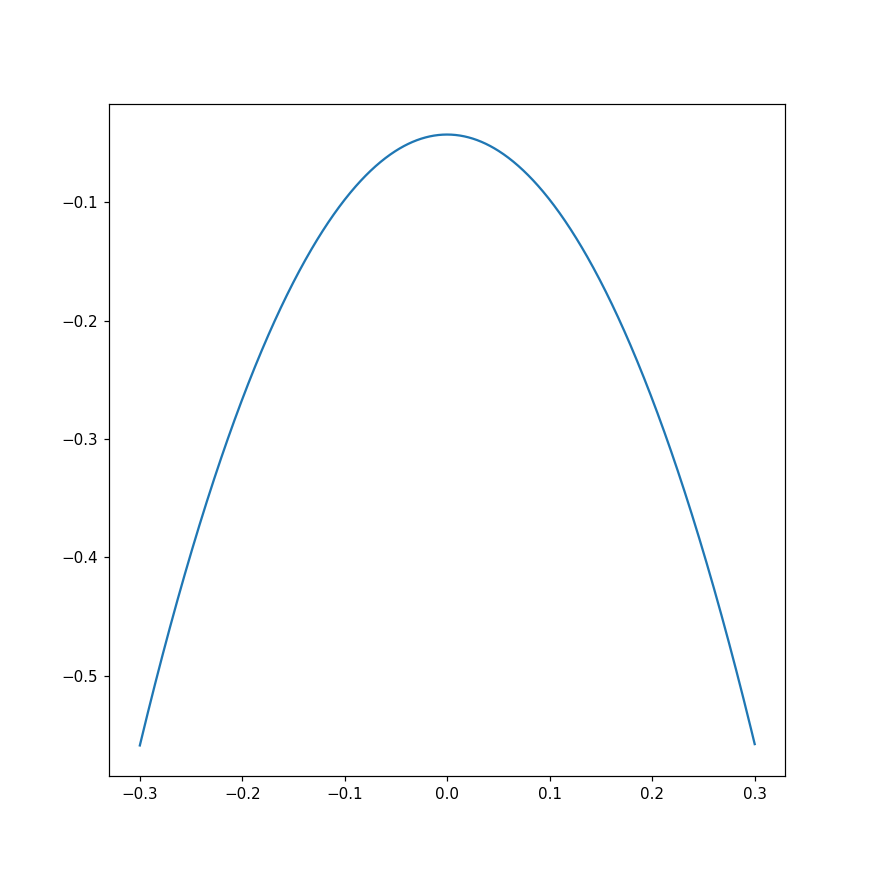

In [122]:
fig = plt.figure(figsize=(8,8))
f = lambdify((px),H_int.ham.subs(x,1.5),'numpy')
xx = np.linspace(-.3,.3,1000)
plt.plot(xx,f(xx))

<IPython.core.display.Javascript object>


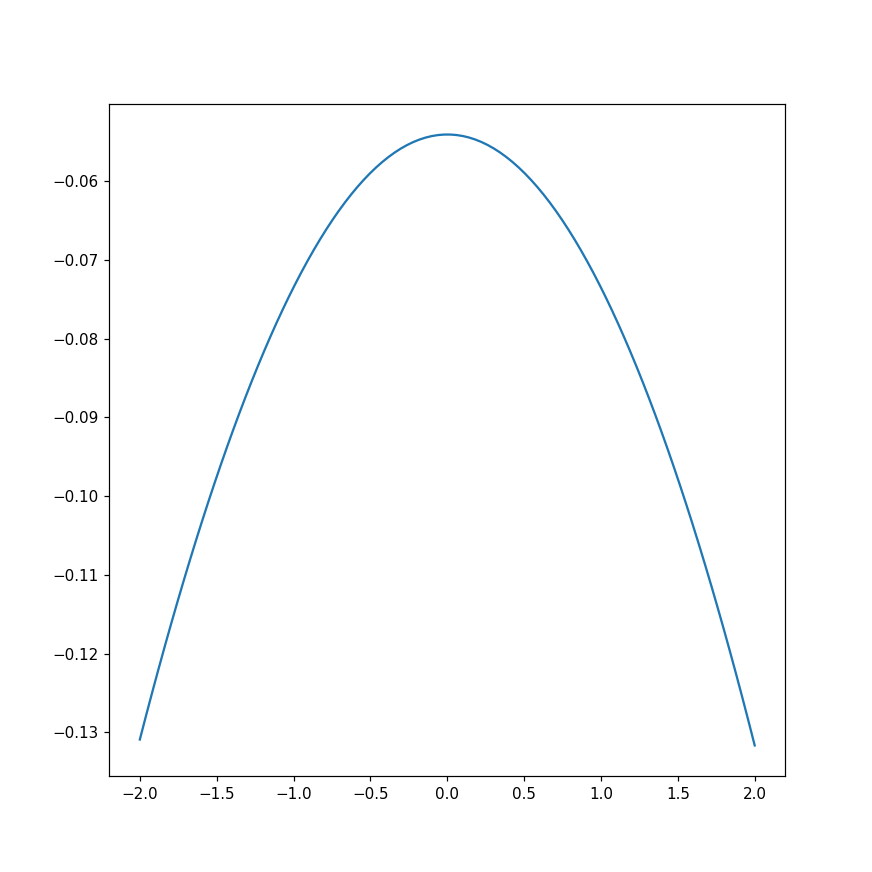

In [132]:
fig = plt.figure(figsize=(8,8))
f = lambdify((x),H_int.ham.subs(px,0.1),'numpy')
xx = np.linspace(-2,2,100)
plt.plot(xx,f(xx))
# for xx in np.linspace(-2,2,10):
#     plt.plot(xx,f(xx))

In [ ]:
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(2, 2)
axes = [fig.add_subplot(gs[i, j]) for j in range(2) for i in range(2)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 15
prange = .4
npoints= 800
X = np.linspace(-xrange, xrange, npoints)
# X = np.linspace(1, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

func1 = lambdify((x,px), H_int.ham.expand().subs(xpx_rep) ,'numpy')
func2 = lambdify((x,px), H_int2.ham.expand().subs(xpx_rep) ,'numpy')
func3 = lambdify((x,px), H_int3.ham.expand().subs(xpx_rep) ,'numpy')

Hlist = [func1(Xg, Pg),func2(Xg,Pg),func3(Xg,Pg)]

cb = axes[0].contour(Xg, Pg, Hlist[0], levels=450,cmap=cm.jet)
axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
axes[2].contour(Xg, Pg, Hlist[2], levels=450,cmap=cm.jet)
plt.colorbar(cb)

In [864]:
H_eff = LieOperator(H_int3.ham,x,px)
f_eff = taylorize(H_eff,8)

KeyboardInterrupt: 

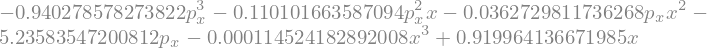

In [862]:
f_eff[0]

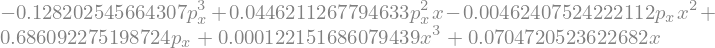

In [863]:
f_eff[1]

In [844]:
f_eff_x = lambdify((x,px),f_eff[0])
f_eff_px = lambdify((x,px),f_eff[1])

In [875]:
LieOperator(AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep), x, px).ham

In [964]:
beamlines.reverse()

In [965]:
beamlines

In [968]:
element_eff = []
taylororder = 12
for element in beamlines:
    print(element[0])
    H0 = AssignHam(element[0],element[1],element[2],element[3],element[4]).subs(xpx_rep).subs(rep)
    print(H0)
    H0 = LieOperator(H0,[x],[px])
    _eff = taylorize(H0,taylororder)
    element_eff.append(_eff)
    

2
-0.01875*p_x**4 - 0.075*p_x**2 - 0.0525*x**2
1
0.146875*p_x**6 + 0.29375*p_x**4 + 1.175*p_x**2
2
-0.05025*p_x**4 - 0.201*p_x**2 + 0.07035*x**2
1
0.159375*p_x**6 + 0.31875*p_x**4 + 1.275*p_x**2
2
-0.01875*p_x**4 - 0.075*p_x**2 - 0.0525*x**2


In [969]:
x_eff = [lambdify((x,px),f_eff[0]) for f_eff in element_eff]
px_eff = [lambdify((x,px),f_eff[1]) for f_eff in element_eff]

In [970]:
#Island setting
_ld1 = 2.55
_ld2 = 2.35#2.48
_lqf = 0.3
_lqd = 0.804
_k1 = 0.7
_k2 = - 0.35
dev = 2.5 * 10e-4

eps = 0
duration = 2**4
#number of turns

def effmap(r):
    _x = r[:,0]
    _px = r[:,1]
    
    xn = f_eff_x(_x,_px)
    pxn = f_eff_px(_x,_px)
    
    z0 = np.zeros(r[:,0].shape)
    return np.array([xn,pxn,z0,z0,z0,z0]).transpose()

def elemeffmap(r):
    _x = r[:,0]
    _px = r[:,1]
    
    for fx, fpx in zip(x_eff,px_eff):
        xn = fx(_x,_px)
        pxn = fpx(_x,_px)
        _x =xn
        _px = pxn
        print(xn, pxn)
    z0 = np.zeros(r[:,0].shape)
    return np.array([xn,pxn,z0,z0,z0,z0]).transpose()

r0 = np.array([
    [10e-7,eps,10e-7,eps,eps,dev],
#                [10e-5,eps,10e-5,eps,eps,dev],
#                [10e-3,eps,10e-3,eps,eps,dev],
#                [10e-1,eps,10e-1,eps,eps,dev],
#                [0.25,eps,0.25,eps,eps,dev],
#                [0.35,eps,0.35,eps,eps,dev],
#                [0.45,eps,0.45,eps,eps,dev],
#                [0.55,eps,0.55,eps,eps,dev],
#                [0.65,eps,0.65,eps,eps,dev],
#                [0.8,eps,0.8,eps,eps,dev],
#                [0.9,eps,0.9,eps,eps,dev],
#                [1,eps,1,eps,eps,dev],
#                [1.1,eps,1.1,eps,eps,dev],
#                [1.2,eps,1.2,eps,eps,dev],
#                [1.3,eps,1.3,eps,eps,dev],
#                [1.4,eps,1.4,eps,eps,dev],
#                [1.5,eps,1.5,eps,eps,dev],
#                [1.6,eps,1.6,eps,eps,dev],
#                [1.7,eps,1.7,eps,eps,dev],
#                [1.8,eps,1.8,eps,eps,dev],
#                [1.9,eps,1.9,eps,eps,dev],
#                [2.0,eps,2.0,eps,eps,dev]
              ]
             )

X_Exact = []
X_lin = []
X_Exact_2 = []
X_Exact_4 = []
X_Exact_6 = []
X_Exact_8 = []

X_Exact = np.array([r0])
X_lin = np.array([r0])
X_Exact_2 = np.array([r0])
X_Exact_4 = np.array([r0])
X_Exact_6 = np.array([r0])
X_Exact_8 = np.array([r0])

for i in tqdm(range(1, duration + 1)):
#     print(X_Exact[-1])
    
    r_exact = effmap(X_Exact[-1])
    r_el = elemeffmap(X_lin[-1])
    
#     print(r_exact)
    
    X_Exact = np.append(X_Exact, [r_exact], axis = 0)
    X_lin = np.append(X_lin, [r_el], axis = 0)

100%|██████████| 16/16 [00:00<00:00, 282.81it/s]

[9.92135331e-07] [-1.04724592e-07]
[1.23823812e-06] [-1.04724592e-07]
[1.23092446e-06] [6.81668473e-08]
[1.05709899e-06] [6.81668473e-08]
[1.05898347e-06] [-4.30735233e-08]
[1.04421083e-06] [-1.53636376e-07]
[1.40525631e-06] [-1.53636376e-07]
[1.38283993e-06] [4.15868859e-08]
[1.27679337e-06] [4.15868859e-08]
[1.27297348e-06] [-9.24518456e-08]
[1.24913056e-06] [-2.25036371e-07]
[1.77796603e-06] [-2.25036371e-07]
[1.73716577e-06] [2.109412e-08]
[1.68337576e-06] [2.109412e-08]
[1.67329239e-06] [-1.55362618e-07]
[1.63688923e-06] [-3.29375605e-07]
[2.4109219e-06] [-3.29375605e-07]
[2.34576571e-06] [3.6889629e-09]
[2.33635885e-06] [3.6889629e-09]
[2.31853606e-06] [-2.41014277e-07]
[2.26424422e-06] [-4.81926522e-07]
[3.39677155e-06] [-4.81926522e-07]
[3.29772232e-06] [-1.31762298e-08]
[3.3313217e-06] [-1.31762298e-08]
[3.30315071e-06] [-3.61943909e-07]
[3.22302334e-06] [-7.0501845e-07]
[4.87981669e-06] [-7.0501845e-07]
[4.7323763e-06] [-3.19700662e-08]
[4.81389997e-06] [-3.19700662e-08]
[4.7

<IPython.core.display.Javascript object>


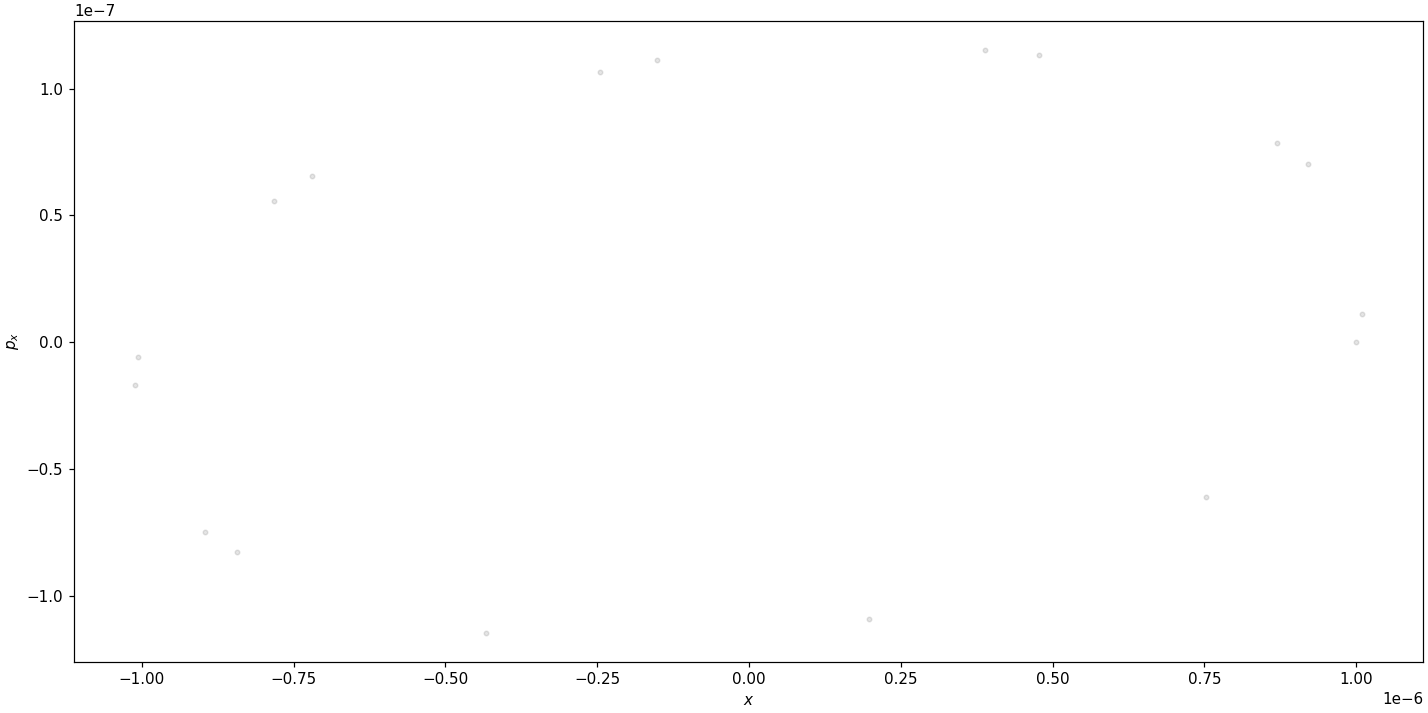

<IPython.core.display.Javascript object>


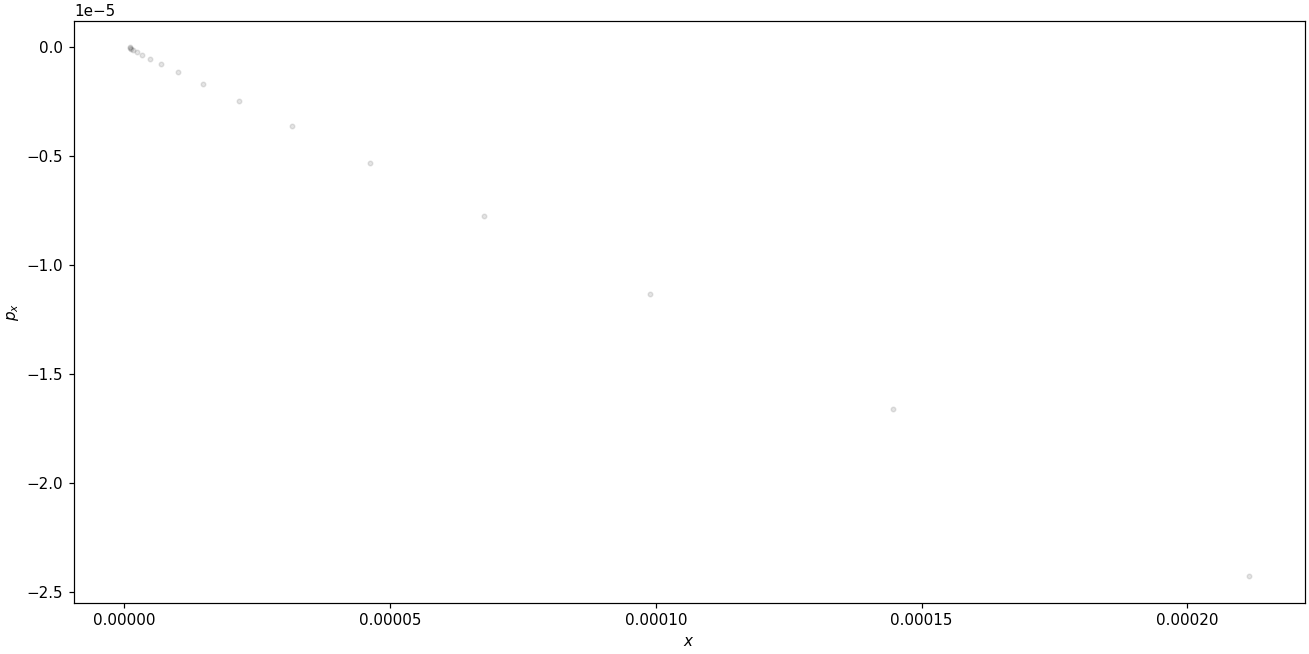

In [971]:
def New_FIG(x,px,y,py):
    fig = plt.figure(constrained_layout=True, figsize = (12,6))
    gs  = fig.add_gridspec(1, 1)

    ax1 = fig.add_subplot(gs[0,0])
#     ax2 = fig.add_subplot(gs[0,1])

#     ax1.set_title('$x-p_x:$ O(8)')
#     ax2.set_title('$y-p_y$')

    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$p_x$')

#     ax2.set_xlabel('$y$')
#     ax2.set_ylabel('$p_y$')
    
    ax1.plot(x,px,'k.',alpha=.1, label='Exact')
#     ax2.plot(y,py,'k.',alpha=.1, label='Exact')
#     plt.savefig('Drift_8.png')


X_Exact_array = np.array(X_Exact)
X_lin_array = np.array(X_lin)
New_FIG(X_Exact_array[:,:,0],X_Exact_array[:,:,1],X_Exact_array[:,:,2],X_Exact_array[:,:,3])
New_FIG(X_lin_array[:,:,0],X_lin_array[:,:,1],X_lin_array[:,:,2],X_lin_array[:,:,3])
# New_FIG(X_Exact_2_array[:,:,0],X_Exact_2_array[:,:,1],X_Exact_2_array[:,:,2],X_Exact_2_array[:,:,3])
# New_FIG(X_Exact_4_array[:,:,0],X_Exact_4_array[:,:,1],X_Exact_4_array[:,:,2],X_Exact_4_array[:,:,3])
# New_FIG(X_Exact_6_array[:,:,0],X_Exact_6_array[:,:,1],X_Exact_4_array[:,:,2],X_Exact_6_array[:,:,3])
# New_FIG(X_Exact_8_array[:,:,0],X_Exact_8_array[:,:,1],X_Exact_6_array[:,:,2],X_Exact_8_array[:,:,3])

# plt.xlim(-3,3)
# plt.ylim(-1,1)
# plt.savefig('Drift_Exact.png')
plt.show()

# Exact tracking

In [89]:
def drift_exact(r,l):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    d = np.sqrt((_pz+1)**2 - _px**2 - _py**2)
    
    xn = _x + l * _px / d
    pxn = _px
    yn = _y + l * _py / d
    pyn = _py
    zn = _z + l * (1-1/d) - _pz*l/d
    pzn = _pz
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()


def drift_lin(r,l):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    xn = _x + l * _px
    pxn = _px
    yn = _y + l * _py
    pyn = _py
    zn = _z
    pzn = _pz
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()

# def drift_4(r,l):
#     _x = r[:,0]
#     _px = r[:,1]
#     _y = r[:,2]
#     _py = r[:,3]
#     _z = r[:,4]
#     _pz = r[:,5]
    
#     d = (_pz+1)**2
    
#     den = 2* (_pz**4 + 4*_pz**3 + 6*_pz**2 + 4*_pz + 1)
    
#     xn = l*_pz _px**3 / den + l*_pz*_px*_py**2 / den + l*_pz*_px / d + l*_px**3 / den + l*_px*_py**2 / den + l*_px / d + x
#     pxn = _px
#     yn = l*_pz*_px**2 *_py / den + l*_pz*_py**3 / den + l*_pz*_py / d + l*_px**2 *_py / den + l*_py**3 / den + l*_py / d + y
#     pyn = _py
#     zn = _z
#     pzn = _pz
    
#     return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()


def quadf_exact(r,l,_k):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
#     D = np.abs(1 + pz)
    D = 1
    
    _k = np.abs(_k/D)

    
    omega = np.sqrt(_k)
    sin = np.sin(omega*l)
    cos = np.cos(omega*l)
    sinh = np.sinh(omega * l)
    cosh = np.cosh(omega * l)
    
    xn = cos * _x + sin * _px / (omega*D)
    pxn = cos * _px - sin * (omega*D) * _x
    yn = cosh * _y + sinh * _py / (omega*D)
    pyn = sinh * (omega*D) * _y + cosh * _py
    zn = _z
    pzn = _pz
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()

def quadff_exact(r,l,_k):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
#     D = np.abs(1 + pz)
    D = 1
    _k = np.abs(_k)
    
    omega = np.sqrt(_k)
    sin = np.sin(omega*l)
    cos = np.cos(omega*l)
    sinh = np.sinh(omega * l)
    cosh = np.cosh(omega * l)
    
    xn = cosh * _x + sinh * _px / (omega*D)
    pxn = cosh * _px + sinh * (omega*D) * _x
    yn = cos * _y + sin * _py / (omega*D)
    pyn = cos * _py - sin * (omega*D) * _y
    zn = _z
    pzn = _pz    
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()

def sext_exact(r,l,_k):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    xn = _x
    pxn = _px - (_k*l)*(_x**2 - _y**2)/2
    yn = _y
    pyn = _py + _k*l*_x*_y
    zn = _z
    pzn = _pz  
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()

In [93]:
sym_x, sym_y, sym_z, sym_px, sym_py, sym_pz, sym_k, sym_l, sym_d, sym_beta = symbols('x y z p_x p_y \delta k_{Q} L D beta')
J = np.array([[0,1,0,0],
              [-1,0,0,0],
              [0,0,0,1],
              [0,0,-1,0]])

i_coord = [sym_x,sym_y]
i_mom = [sym_px,sym_py]
tot_coords = [sym_x,sym_px,sym_y,sym_py]





_epstemp = symbols('e')

HD_2 = AssignHam(*[eldict['drift'], 2, LD , Zero(), 0   ])
HD_4 = AssignHam(*[eldict['drift'], 4, LD , Zero(), 0   ])
HD_6 = AssignHam(*[eldict['drift'], 6, LD , Zero(), 0   ])
HD_8 = AssignHam(*[eldict['drift'], 8, LD , Zero(), 0   ])

$$\delta - \left(\delta + 1\right) \left(- \frac{p_{x}^{2}}{2 \left(\delta + 1\right)} - \frac{p_{y}^{2}}{2 \left(\delta + 1\right)} + 1\right)$$

In [240]:
rep = list(zip(
    [
        LD,
        LD2,
        LQF,
        LQD,
        KQF,
        KQD,
#         delta,
        dld
    ],
    [
        3.5805,
        3.5805,
        0.342,
        0.668,
        0.49,
        -0.4999,
#         1.5e-3,
        0
    ]
)
          )


In [241]:
L_drift_2 = LieOperator(HD_2,[x,y],[px,py])
f_drift_2 = taylorize(L_drift_2.subs(rep),20)

L_drift_4 = LieOperator(HD_4,[x,y],[px,py])
f_drift_4 = taylorize(L_drift_4.subs(rep),20)

L_drift_6 = LieOperator(HD_6,[x,y],[px,py])
f_drift_6 = taylorize(L_drift_6.subs(rep),20)

L_drift_8 = LieOperator(HD_8,[x,y],[px,py])
f_drift_8 = taylorize(L_drift_8.subs(rep),20)

In [244]:
f_drift_4

In [246]:
f_x_2 = lambdify((x,px,y,py,delta),f_drift_2[0])
f_y_2 = lambdify((x,px,y,py,delta),f_drift_2[2])

f_x_4 = lambdify((x,px,y,py,delta),f_drift_4[0])
f_y_4 = lambdify((x,px,y,py,delta),f_drift_4[2])

f_x_6 = lambdify((x,px,y,py,delta),f_drift_6[0])
f_y_6 = lambdify((x,px,y,py,delta),f_drift_6[2])

f_x_8 = lambdify((x,px,y,py,delta),f_drift_8[0])
f_y_8 = lambdify((x,px,y,py,delta),f_drift_8[2])

In [250]:
def drift_2(r):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    xn = f_x_2(_x,_px,_y,_py,_pz)
    pxn = _px
    yn = f_y_2(_x,_px,_y,_py,_pz)
    pyn = _py
    zn = _z
    pzn = _pz
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()

def drift_4(r):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    xn = f_x_4(_x,_px,_y,_py,_pz)
    pxn = _px
    yn = f_y_4(_x,_px,_y,_py,_pz)
    pyn = _py
    zn = _z
    pzn = _pz
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()

def drift_6(r):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    xn = f_x_6(_x,_px,_y,_py,_pz)
    pxn = _px
    yn = f_y_6(_x,_px,_y,_py,_pz)
    pyn = _py
    zn = _z
    pzn = _pz
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()

def drift_8(r):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    xn = f_x_8(_x,_px,_y,_py,_pz)
    pxn = _px
    yn = f_y_8(_x,_px,_y,_py,_pz)
    pyn = _py
    zn = _z
    pzn = _pz
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()


In [443]:

_ld1 = 2.55
_ld2 = 2.35#2.48
_lqf = 0.3
_lqd = 0.804
_k1 = 0.7
_k2 = - 0.35


_lqf = float(LQF.subs(rep))
_lqd = float(LQD.subs(rep))
_k1 = float(KQF.subs(rep))
_k2 = float(KQD.subs(rep))

_ld1 = float(LD.subs(rep))
dev = 0 # 2.5 * 10e-4

eps = 0
duration = 2**12# number of turns    

r0 = np.array([
#                 [10e-7,eps,10e-7,eps,eps,dev],
#                [10e-5,eps,10e-5,eps,eps,dev],
#                [10e-3,eps,10e-3,eps,eps,dev],
#                [10e-1,eps,10e-1,eps,eps,dev],
#                [0.25,eps,0.25,eps,eps,dev],
#                [0.35,eps,0.,eps,eps,dev],
#     [1.675,0.065,0.,eps,eps,dev],
#      [1.500,0.299,0,eps,eps,dev],
#     [1.500,0.3,0.,eps,eps,dev],
#     [1.725,0.065,0.,eps,eps,dev],
#     [1.750,0.065,0.,eps,eps,dev],
#     [2.00,0.05,0.,eps,eps,dev],
#      [1.95,0.05,0.,eps,eps,dev],
#     [1.92,0.05,0.,eps,eps,dev],
#     [1.92,0.05,0.,eps,eps,dev],
#     [1.95,0.055,0.,eps,eps,dev],
    [1.85,0.05,0.,eps,eps,dev],
#     [1.9,0.05,0.,eps,eps,dev],
#     [1.95,0.05,0.,eps,eps,dev],
#                [0.45,eps,0.45,eps,eps,dev],
#                [0.55,eps,0.55,eps,eps,dev],
#                [0.65,eps,0.65,eps,eps,dev],
#                [0.8,eps,0.8,eps,eps,dev],
#                [0.9,eps,0.9,eps,eps,dev],
#                [1,eps,1,eps,eps,dev],
#                [1.1,eps,1.1,eps,eps,dev],
#                [1.2,eps,1.2,eps,eps,dev],
#                [1.3,eps,1.3,eps,eps,dev],
#                [1.4,eps,1.4,eps,eps,dev],
#                [1.5,eps,1.5,eps,eps,dev],
#                [1.6,eps,1.6,eps,eps,dev],
#                [1.7,eps,1.7,eps,eps,dev],
#                [1.8,eps,1.8,eps,eps,dev],
#                [1.9,eps,1.9,eps,eps,dev],
#                [2.0,eps,2.0,eps,eps,dev]
              ])

X_Exact = []
X_lin = []
X_Exact_2 = []
X_Exact_4 = []
X_Exact_6 = []
X_Exact_8 = []

X_Exact = np.array([r0])
X_lin = np.array([r0])
X_Exact_2 = np.array([r0])
X_Exact_4 = np.array([r0])
X_Exact_6 = np.array([r0])
X_Exact_8 = np.array([r0])

def FODO_Exact(_x0):
    r = quadf_exact(_x0,_lqf,_k1)
    r = drift_exact(r,_ld1)
    r = quadff_exact(r,_lqd,_k2)
#     r = drift_exact(r,_lds1)
#     r = sext_exact(r,_lsext,_k3)
#     r = drift_exact(r,_lds2)
#     r = quadff_exact(r,_lqd,_k2)
    r = drift_exact(r,_ld1)
    r = quadf_exact(r,_lqf,_k1)
    return r

# def FODO_lin(_x0):
#     r = quadf_exact(_x0,_lqf,_k1)
#     r = drift_lin(r,_ld1)
#     r = quadff_exact(r,_lqd,_k2)
# #     r = drift_exact(r,_lds1)
# #     r = sext_exact(r,_lsext,_k3)
# #     r = drift_exact(r,_lds2)
# #     r = quadff_exact(r,_lqd,_k2)
#     r = drift_lin(r,_ld2)
#     r = quadf_exact(r,_lqf,_k1)
#     return r

def FODO_2(_x0):
    r = quadf_exact(_x0,_lqf,_k1)
    r = drift_2(r)
    r = quadff_exact(r,_lqd,_k2)
#     r = drift_exact(r,_lds1)
#     r = sext_exact(r,_lsext,_k3)
#     r = drift_exact(r,_lds2)
#     r = quadff_exact(r,_lqd,_k2)
    r = drift_2(r)
    r = quadf_exact(r,_lqf,_k1)
    return r
    
def FODO_4(_x0):
    r = quadf_exact(_x0,_lqf,_k1)
    r = drift_4(r)
    r = quadff_exact(r,_lqd,_k2)
#     r = drift_exact(r,_lds1)
#     r = sext_exact(r,_lsext,_k3)
#     r = drift_exact(r,_lds2)
#     r = quadff_exact(r,_lqd,_k2)
    r = drift_4(r)
    r = quadf_exact(r,_lqf,_k1)
    return r
    
def FODO_6(_x0):
    r = quadf_exact(_x0,_lqf,_k1)
    r = drift_6(r)
    r = quadff_exact(r,_lqd,_k2)
#     r = drift_exact(r,_lds1)
#     r = sext_exact(r,_lsext,_k3)
#     r = drift_exact(r,_lds2)
#     r = quadff_exact(r,_lqd,_k2)
    r = drift_6(r)
    r = quadf_exact(r,_lqf,_k1)
    return r
    
def FODO_8(_x0):
    r = quadf_exact(_x0,_lqf,_k1)
    r = drift_8(r)
    r = quadff_exact(r,_lqd,_k2)
#     r = drift_exact(r,_lds1)
#     r = sext_exact(r,_lsext,_k3)
#     r = drift_exact(r,_lds2)
#     r = quadff_exact(r,_lqd,_k2)
    r = drift_8(r)
    r = quadf_exact(r,_lqf,_k1)
    return r

for i in tqdm(range(1, duration + 1)): 
    
    r_exact = FODO_Exact(X_Exact[-1])
#     r_lin = FODO_lin(X_lin[-1])
    r_2 = FODO_2(X_Exact_2[-1])
    r_4 = FODO_4(X_Exact_4[-1])
    r_6 = FODO_6(X_Exact_6[-1])
    r_8 = FODO_8(X_Exact_8[-1])


    X_Exact = np.append(X_Exact, [r_exact], axis = 0)
#     X_lin = np.append(X_lin, [r_lin], axis = 0)
    X_Exact_2 = np.append(X_Exact_2, [r_2], axis = 0)
    X_Exact_4 = np.append(X_Exact_4, [r_4], axis = 0)
    X_Exact_6 = np.append(X_Exact_6, [r_6], axis = 0)
    X_Exact_8 = np.append(X_Exact_8, [r_8], axis = 0)

  1%|▏         | 61/4096 [00:00<00:06, 605.80it/s]<lambdifygenerated-78>:2: RuntimeWarning: overflow encountered in power
  return (-3.5805*delta**6*p_x + 3.5805*delta**5*p_x - 26.85375*delta**4*p_x**3 - 26.85375*delta**4*p_x*p_y**2 - 3.5805*delta**4*p_x + 17.9025*delta**3*p_x**3 + 17.9025*delta**3*p_x*p_y**2 + 3.5805*delta**3*p_x - 20.1403125*delta**2*p_x**5 - 40.280625*delta**2*p_x**3*p_y**2 - 10.7415*delta**2*p_x**3 - 20.1403125*delta**2*p_x*p_y**4 - 10.7415*delta**2*p_x*p_y**2 - 3.5805*delta**2*p_x + 6.7134375*delta*p_x**5 + 13.426875*delta*p_x**3*p_y**2 + 5.37075*delta*p_x**3 + 6.7134375*delta*p_x*p_y**4 + 5.37075*delta*p_x*p_y**2 + 3.5805*delta*p_x - 1.11890625*p_x**7 - 3.35671875*p_x**5*p_y**2 - 1.3426875*p_x**5 - 3.35671875*p_x**3*p_y**4 - 2.685375*p_x**3*p_y**2 - 1.79025*p_x**3 - 1.11890625*p_x*p_y**6 - 1.3426875*p_x*p_y**4 - 1.79025*p_x*p_y**2 - 3.5805*p_x + x)
<lambdifygenerated-79>:2: RuntimeWarning: overflow encountered in power
  return (-3.5805*delta**6*p_y + 3.5805*delt

<IPython.core.display.Javascript object>


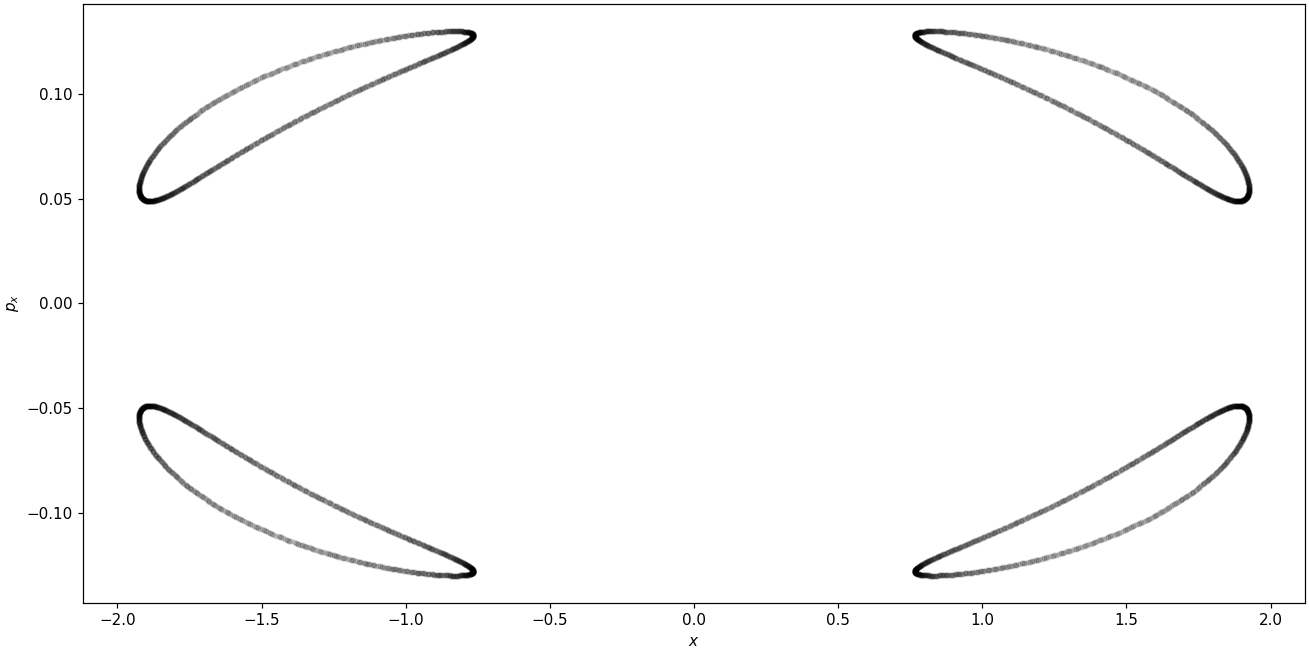

<IPython.core.display.Javascript object>


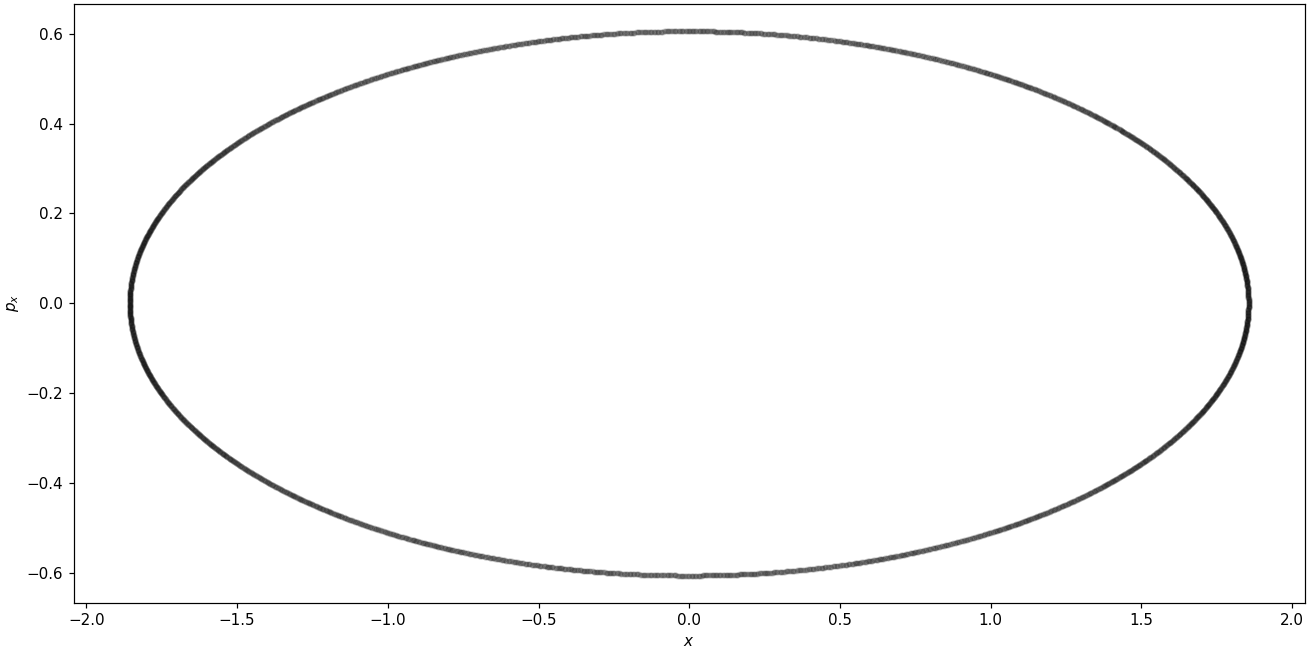

<IPython.core.display.Javascript object>


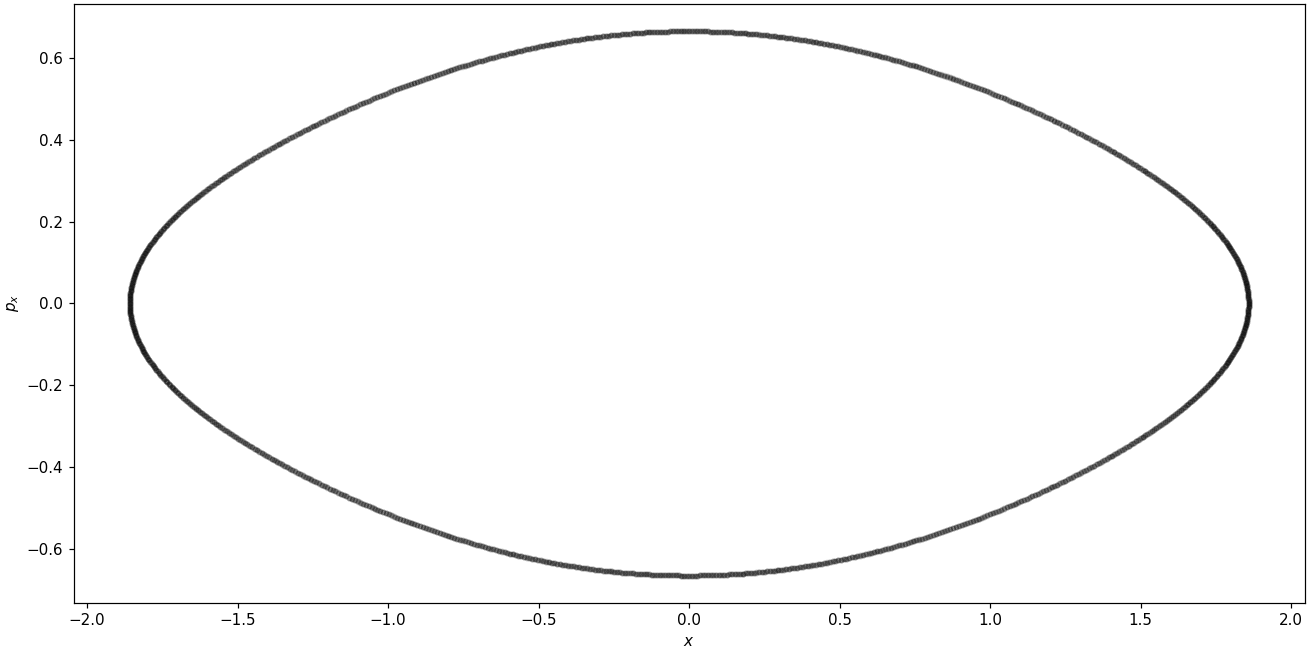

<IPython.core.display.Javascript object>


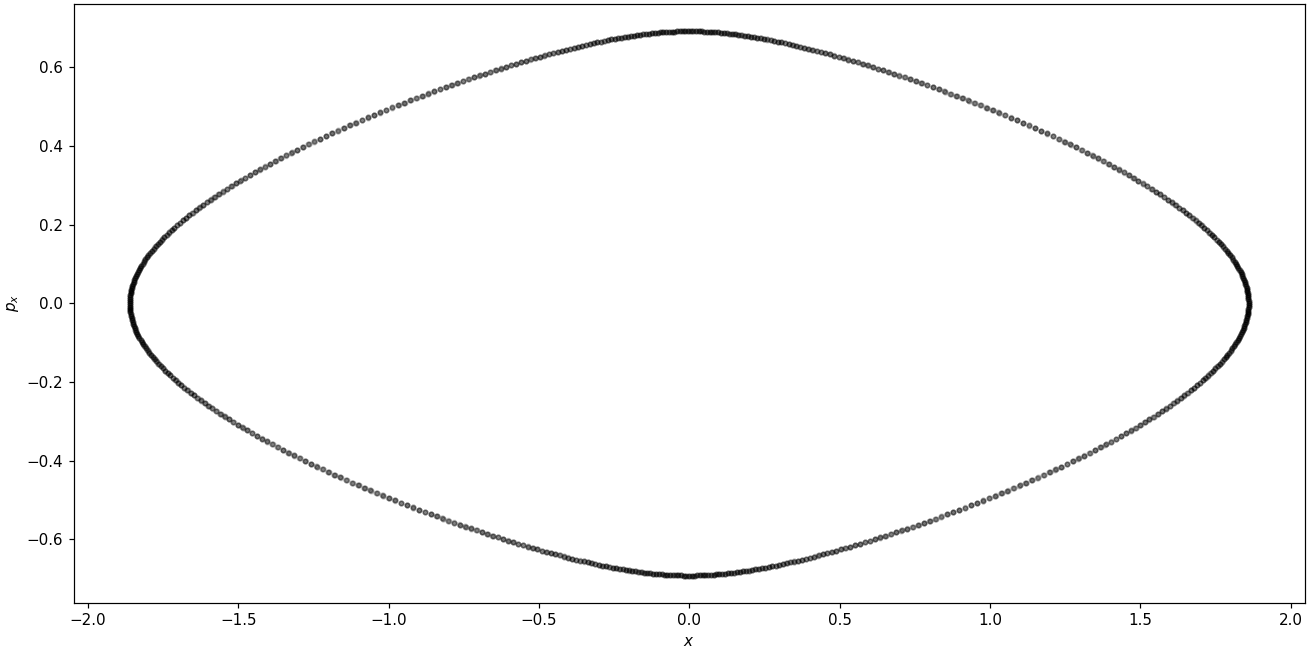

<IPython.core.display.Javascript object>


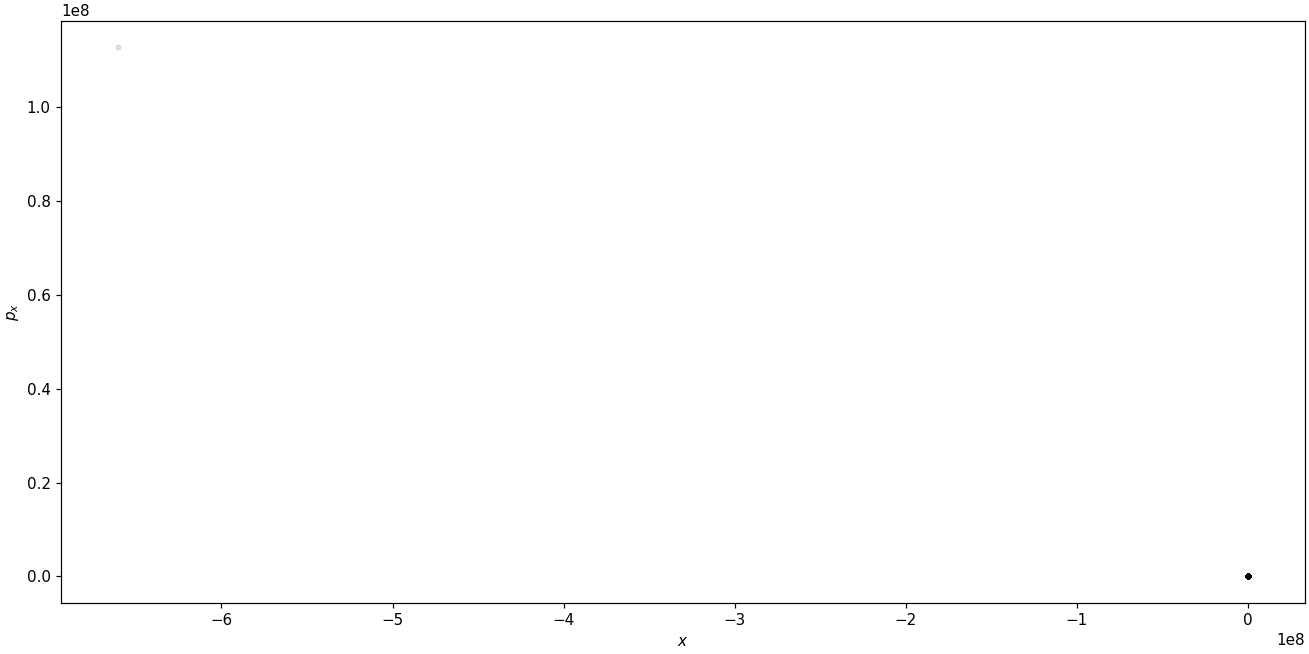

In [444]:
def New_FIG(x,px,y,py):
    fig = plt.figure(constrained_layout=True, figsize = (12,6))
    gs  = fig.add_gridspec(1, 1)

    ax1 = fig.add_subplot(gs[0,0])
#     ax2 = fig.add_subplot(gs[0,1])

#     ax1.set_title('$x-p_x:$ O(8)')
#     ax2.set_title('$y-p_y$')

    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$p_x$')

#     ax2.set_xlabel('$y$')
#     ax2.set_ylabel('$p_y$')
    
    ax1.plot(x,px,'k.',alpha=.1, label='Exact')
#     ax2.plot(y,py,'k.',alpha=.1, label='Exact')
#     plt.savefig('Drift_8.png')

X_Exact_array = np.array(X_Exact)
# X_lin_array = np.array(X_lin)
X_Exact_2_array = np.array(X_Exact_2)
X_Exact_4_array = np.array(X_Exact_4)
X_Exact_6_array = np.array(X_Exact_6)
X_Exact_8_array = np.array(X_Exact_8)
# X_lin_array = np.array(X_lin)
New_FIG(X_Exact_array[:,:,0],X_Exact_array[:,:,1],X_Exact_array[:,:,2],X_Exact_array[:,:,3])
# New_FIG(X_lin_array[:,:,0],X_lin_array[:,:,1],X_lin_array[:,:,2],X_lin_array[:,:,3])
New_FIG(X_Exact_2_array[:,:,0],X_Exact_2_array[:,:,1],X_Exact_2_array[:,:,2],X_Exact_2_array[:,:,3])
New_FIG(X_Exact_4_array[:,:,0],X_Exact_4_array[:,:,1],X_Exact_4_array[:,:,2],X_Exact_4_array[:,:,3])
New_FIG(X_Exact_6_array[:,:,0],X_Exact_6_array[:,:,1],X_Exact_4_array[:,:,2],X_Exact_6_array[:,:,3])
New_FIG(X_Exact_8_array[:,:,0],X_Exact_8_array[:,:,1],X_Exact_6_array[:,:,2],X_Exact_8_array[:,:,3])

# plt.xlim(-3,3)
# plt.ylim(-1,1)
# plt.savefig('Drift_Exact.png')
plt.show()